In [1]:
import sys; sys.path.append('..')
import functools
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import  models
from torchvision.utils import make_grid

In [2]:
class VGG16(nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super().__init__()
        vgg_jittor = models.vgg16(pretrained=pretrained)
        vgg_pretrained_features = vgg_jittor.features

        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        return h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3

vgg16 = VGG16().cuda()

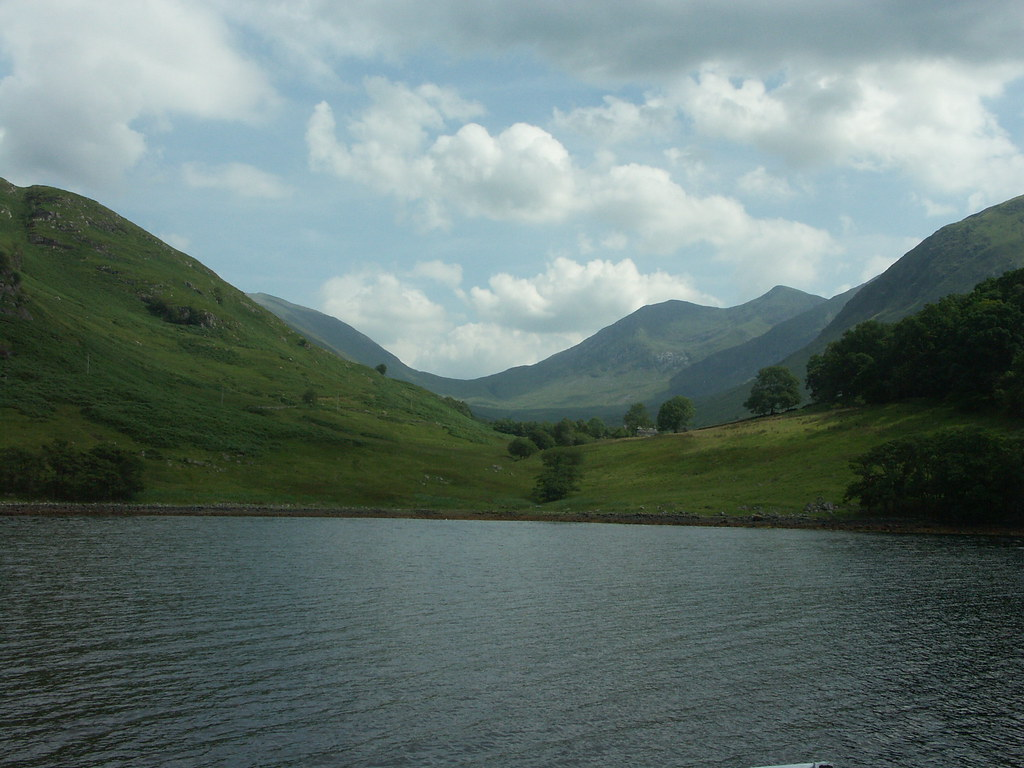

torch.Size([1, 64, 384, 512])
torch.Size([1, 128, 192, 256])
torch.Size([1, 256, 96, 128])
torch.Size([1, 512, 48, 64])


In [3]:
image = Image.open('/nas/landscape/train_val/images/6737198563_602ccf89d5_b.jpg').convert('RGB')
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(384),
    transforms.ToTensor(), 
    transforms.Normalize(mean=MEAN, std=STD),
])
image.show()
image = transform(image)[None, ...].cuda()
target_features = vgg16(image)
for t in target_features:
    print(t.shape)

In [4]:
def unnormalize(img):
    img = image.detach().cpu()
    mean = torch.tensor(MEAN).reshape(1, 3, 1, 1)
    std = torch.tensor(STD).reshape(1, 3, 1, 1)
    return (img * std) + mean

In [5]:
noise = torch.rand_like(image, requires_grad=True)
optimizer = torch.optim.Adam([noise], lr=0.001)
imgs = [noise.detach().cpu()]
for i in range(2000):
    loss = F.l1_loss(vgg16(noise)[3], target_features[3])
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(loss.item())
        imgs.append(unnormalize(noise))

0.20824378728866577
0.1611649990081787
0.1495572030544281
0.13933883607387543
0.13222287595272064
0.12763889133930206
0.12402131408452988
0.12109091132879257
0.11812770366668701
0.11649547517299652
0.114777110517025
0.11358630657196045
0.11166512966156006
0.11041321605443954
0.10941833257675171
0.10812785476446152
0.10799483954906464
0.10721699893474579
0.10657362639904022
0.10581833124160767


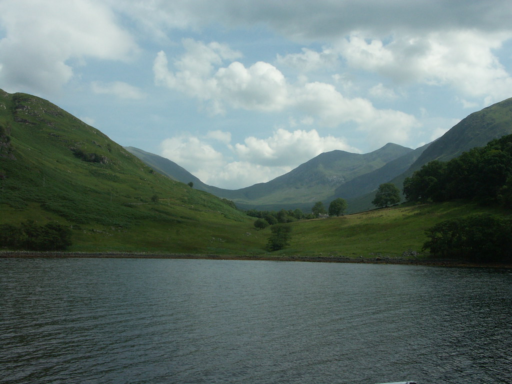

In [6]:
transforms.ToPILImage()(imgs[-1][0].clamp(0, 1))

In [7]:
img_v = torch.cat(imgs, dim=0)
print(img_v.shape, img_v.mean(), img_v.max(), img_v.min())
img_v = np.clip(img_v, -1, 1)
print(img_v.mean())

torch.Size([21, 3, 384, 512]) tensor(0.4385) tensor(1.0000) tensor(5.0826e-06)
tensor(0.4385)


torch.Size([3, 1546, 3086])


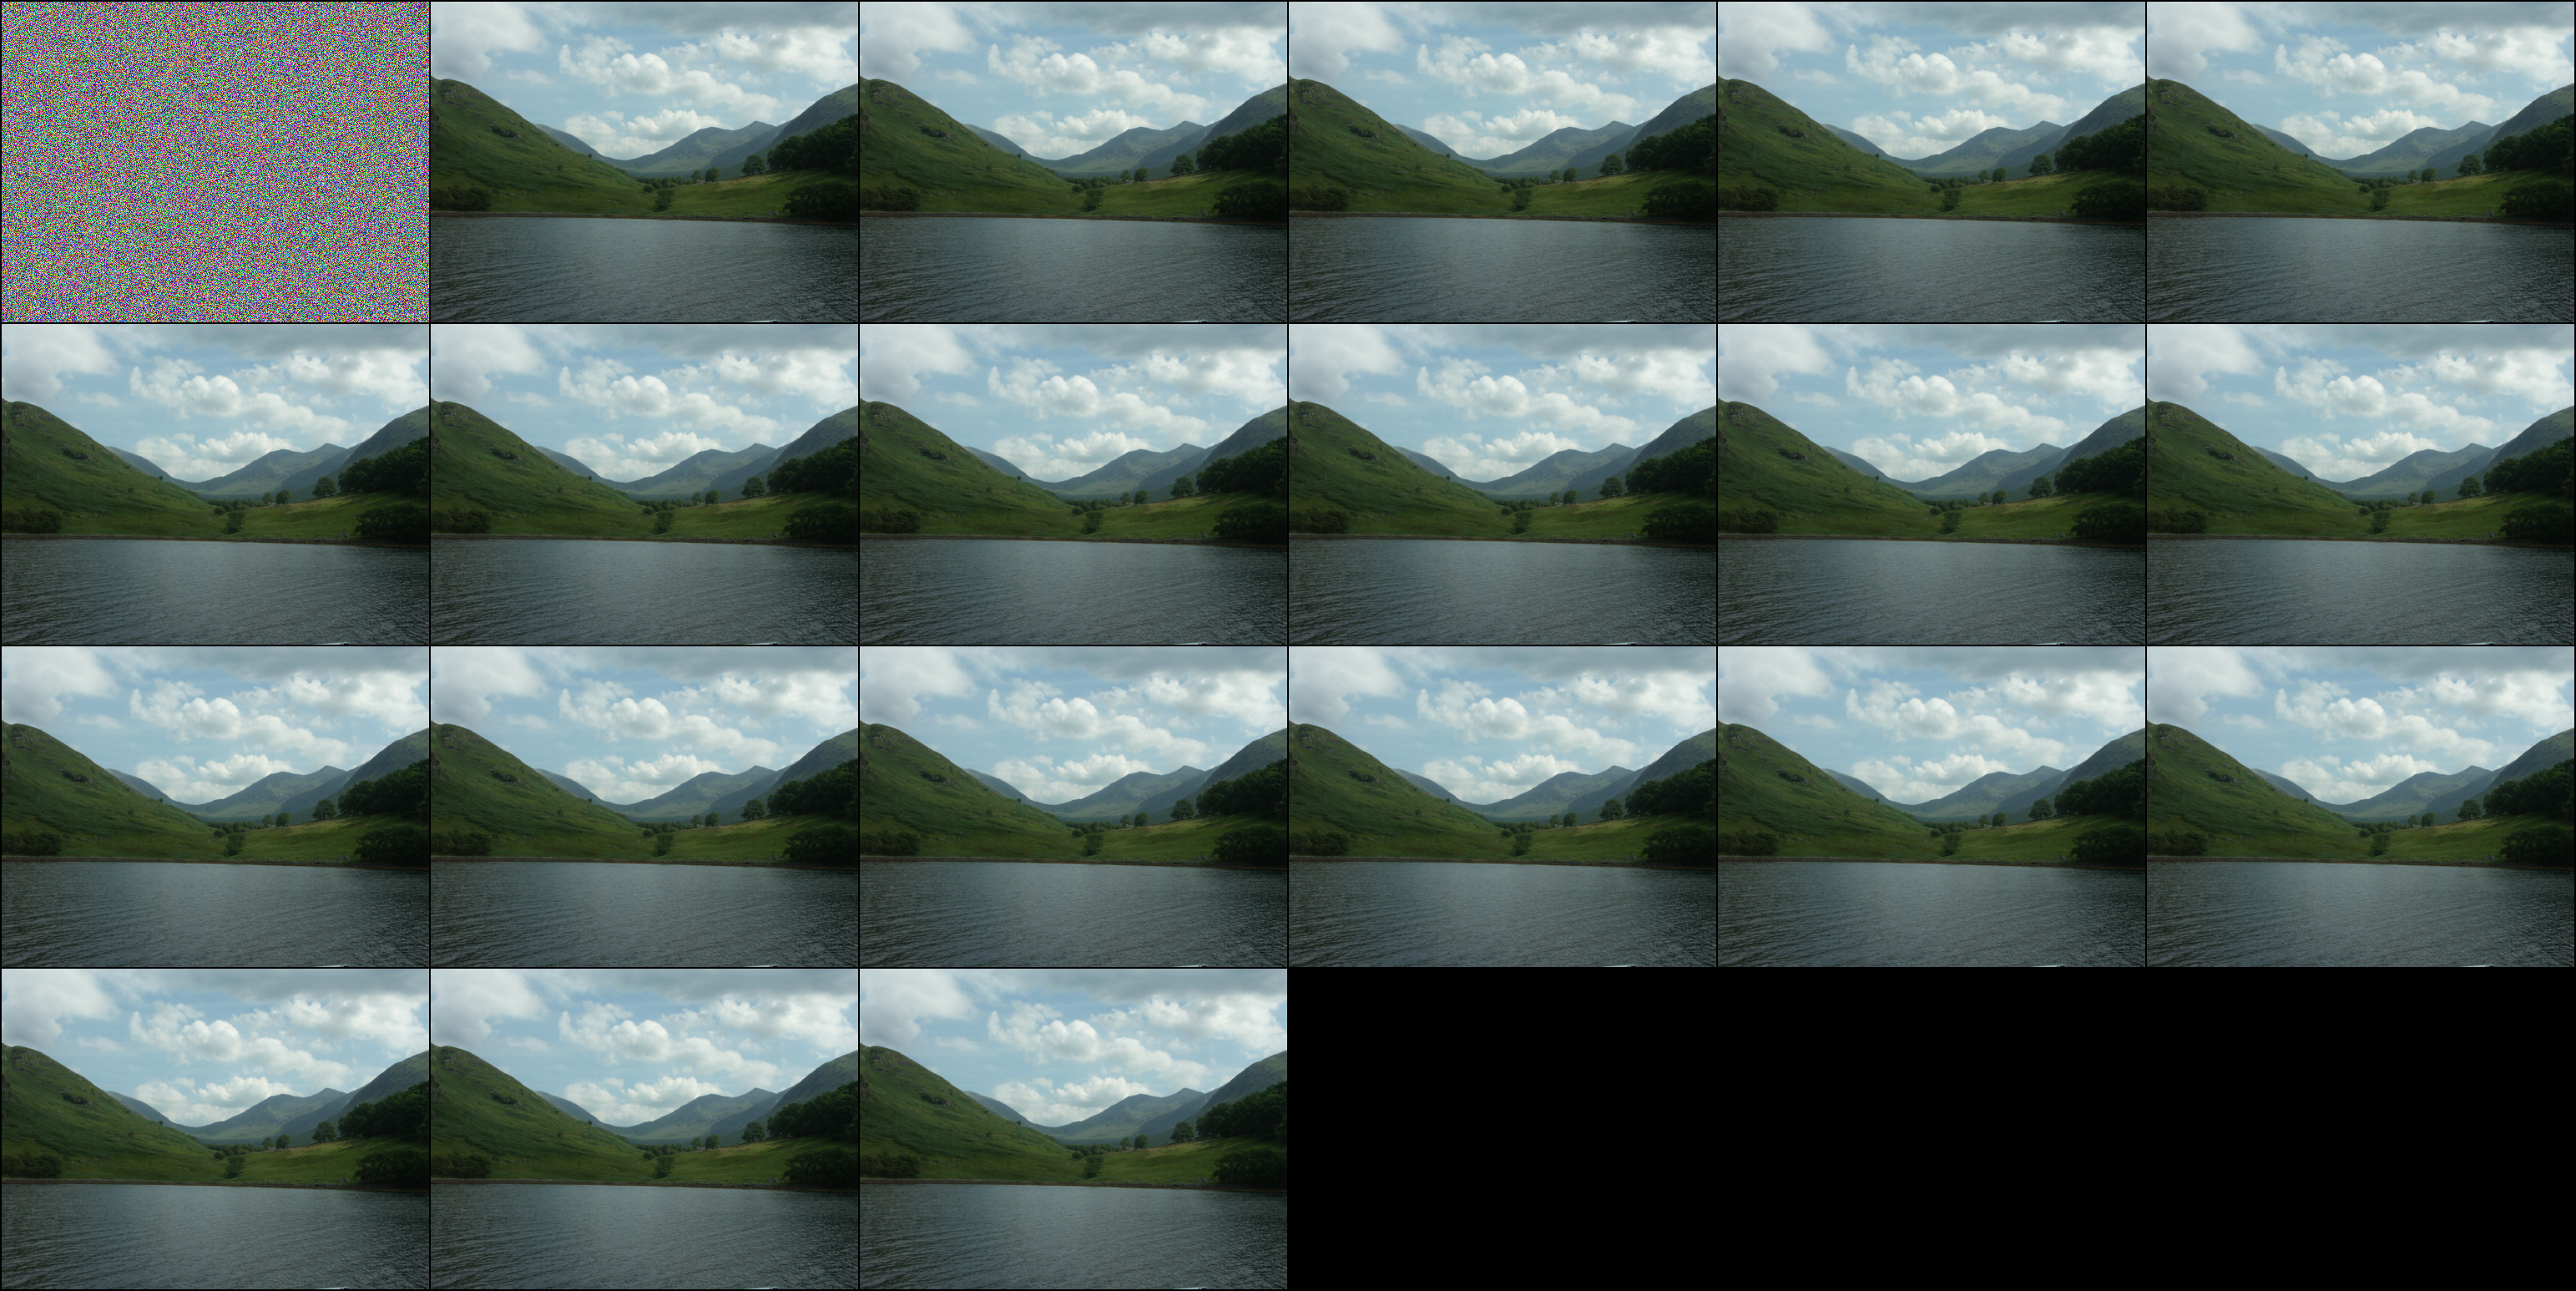

In [8]:
img_grid = make_grid(img_v, 6)
print(img_grid.shape)
transforms.ToPILImage()(img_grid)